# HW1 - Q3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import BSpline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut

In [2]:
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.

    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

(1000,)


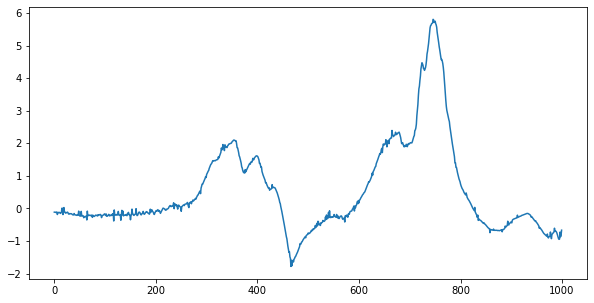

In [3]:
# Import the data, calculate mean
data = pd.read_csv('Question3.csv', header=None) # 40 = num of samples, 1000 = num of features
y_true = np.array(data.mean(axis=0)) # avg of each feature
print(y_true.shape)

# Recreate plot
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(y_true)

## Part A - Cubic Spline  
**Vary the number of knots from 5 to 50 and use 5-fold cross validation to determine the optimal number of knots. Report the optimal number of knots and the cross validation MSE.**

In [4]:
X = np.linspace(0,1,1000)
# X = data.values

# Split data into Training and Test
k_fold = KFold(n_splits=5, shuffle = True)
k_fold.get_n_splits(X)

# 1. Loop through k knots
final_mse = []

for k in range(5,51):

    # 2. For each k, loop through the 5 train/test sets. 
    # Calculate MSE for each set and take avg as final MSE for the knot.
    
    k_mse = []
    
    for train_index, test_index in k_fold.split(X): 
                
        # Define train/test set
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y_true[train_index]
        y_test = y_true[test_index]
        N = len(X_train)
        N_test = len(X_test)
        knots = np.linspace(0, 1, k)
    
        # Find least square estimate using cubic spline and training data
        H = []
        H.append(np.ones((X_train.shape[0], 1)))
        H.append(X_train.reshape(N, -1))
        H.append(X_train.reshape(N, -1)**2)
        H.append(X_train.reshape(N, -1)**3)
        
        for kk in knots:
            H.append(np.maximum((X_train-kk)**3, 0).reshape(N, -1))
                        
        H = np.hstack(H)
        
        # Final coefficients from training data
        B = np.linalg.lstsq(H, y_train,rcond=-1)[0]
        
        # Format H matrix for test data
        H_test = []
        H_test.append(np.ones((X_test.shape[0], 1)))
        H_test.append(X_test.reshape(N_test, -1))
        H_test.append(X_test.reshape(N_test, -1)**2)
        H_test.append(X_test.reshape(N_test, -1)**3)
        
        for kk in knots:
            H_test.append(np.maximum((X_test-kk)**3, 0).reshape(N_test, -1))
                        
        H_test = np.hstack(H_test)
        
        # Calculate y_pred
        y_pred = H_test@B

        # Calculate MSE for each fold and append to k_mse
        test_k_mse = mean_squared_error(y_test, y_pred)
        k_mse.append(test_k_mse)
        
    # Final MSE for k
    final_k_mse = np.mean(k_mse)
        
    # Append (k, mse) to final_mse
    final_mse.append([k, final_k_mse])

# Convert to array
final_mse = np.array(final_mse)

Optimal Number of Knots: 46
Cross Validation MSE at Optimal Number of Knots: 0.007096873245688714


Text(0.5, 1.0, 'Cubic Spline')

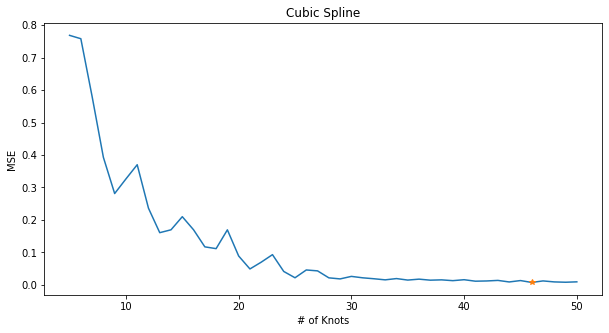

In [5]:
# Get min. MSE
min_mse_loc = np.where(final_mse == np.min(final_mse))
x_min, y_min = final_mse[min_mse_loc[0]][0,0], final_mse[min_mse_loc[0]][0,1]
print("Optimal Number of Knots: " + str(round(x_min)))
print("Cross Validation MSE at Optimal Number of Knots: " + str(y_min))

# Generate plot
x_plt, y_plt = final_mse.T

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(x_plt, y_plt)
plt.plot(x_min, y_min, marker='*')

plt.xlabel("# of Knots")
plt.ylabel("MSE")
plt.title('Cubic Spline')

In [6]:
N_final = len(X)
knots = np.linspace(0, 1, int(x_min))

# Get B matrix based on training data + x_min knots
H = []
H.append(np.ones((X_train.shape[0], 1)))
H.append(X_train.reshape(N, -1))
H.append(X_train.reshape(N, -1)**2)
H.append(X_train.reshape(N, -1)**3)

for kk in knots:
    H.append(np.maximum((X_train-kk)**3, 0).reshape(N, -1))
                        
H = np.hstack(H)
        
# Final coefficients from training data and corresponding k
B = np.linalg.lstsq(H, y_train,rcond=-1)[0]

# Format H matrix for full dataset
H_final = []
H_final.append(np.ones((X.shape[0], 1)))
H_final.append(X.reshape(N_final, -1))
H_final.append(X.reshape(N_final, -1)**2)
H_final.append(X.reshape(N_final, -1)**3)

for kk in knots:
    H_final.append(np.maximum((X-kk)**3, 0).reshape(N_final, -1))
                        
H_final = np.hstack(H_final)
        
# Calculate y_pred
y_pred_cubic_spline = H_final@B

# Calculate MSE for each fold and append to k_mse
mse = mean_squared_error(y_true, y_pred_cubic_spline)


In [7]:
print("----- Results: Cubic Spline -----")
print("Optimal # of Knots = " + str(46))
print("MSE of Full Dataset using Optimal # of Knots: " +str(mse))

----- Results: Cubic Spline -----
Optimal # of Knots = 46
MSE of Full Dataset using Optimal # of Knots: 0.006573131000132258


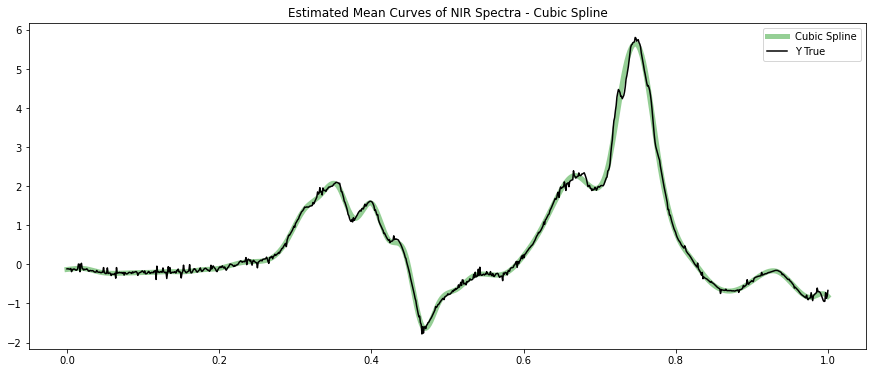

In [8]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(X, y_pred_cubic_spline, 'tab:green',  linewidth=5, alpha=0.5, label ='Cubic Spline')
plt.plot(X, y_true, 'black', label='Y True')


plt.legend()
plt.title('Estimated Mean Curves of NIR Spectra - Cubic Spline')
plt.show()

## Part B - Cubic B-Splines
**Vary the number of knots from 5 to 50 and use 5-fold cross validation to determine the optimal number of knots. Report the optimal number of knots and the cross validation MSE.**


In [9]:
X = np.linspace(0,1,1000)

# Split data into Training and Test
k_fold = KFold(n_splits=5, shuffle = True)
k_fold.get_n_splits(X)

# 1. Loop through k knots
final_mse = []

for k in range(5,51):
    
    # 2. For each k, loop through the 5 train/test sets. 
    # Calculate MSE for each set and take avg as final MSE for the knot.
    
    k_mse = []
    
    for train_index, test_index in k_fold.split(X): 
              
        knots = np.linspace(0, 1, k)
        B = BSplineBasis(X, knots, 3)[:,:-2]
        
        X_train = B[train_index]
        X_test = B[test_index]
        y_train = y_true[train_index]
        y_test = y_true[test_index]
        
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        
        test_k_mse = mean_squared_error(y_test, y_pred)
        k_mse.append(test_k_mse)
        
    # Final MSE for k
    final_k_mse = np.mean(k_mse)
        
    # Append (k, mse) to final_mse
    final_mse.append([k, final_k_mse])

# Convert to array
final_mse = np.array(final_mse)

Optimal Number of Knots: 46
Cross Validation MSE at Optimal Number of Knots: 0.007042850916698635


Text(0.5, 1.0, 'Cubic BSpline')

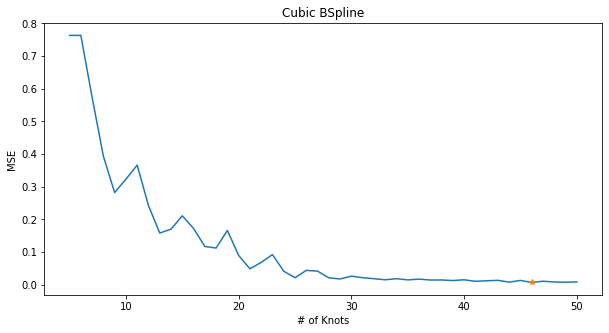

In [10]:
# Get min. MSE
min_mse_loc = np.where(final_mse == np.min(final_mse))
x_min, y_min = final_mse[min_mse_loc[0]][0,0], final_mse[min_mse_loc[0]][0,1]
print("Optimal Number of Knots: " + str(round(x_min)))
print("Cross Validation MSE at Optimal Number of Knots: " + str(y_min))

# Generate plot
x_plt, y_plt = final_mse.T

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(x_plt, y_plt)
plt.plot(x_min, y_min, marker='*')

plt.xlabel("# of Knots")
plt.ylabel("MSE")
plt.title('Cubic BSpline')

In [11]:
knots = np.linspace(0, 1, int(x_min))

B = BSplineBasis(X, knots, 3)[:,:-2]
y_pred_cubic_bspline = np.linalg.lstsq(B.T, B.T@y_true, rcond=-1)[0]      

# Calculate MSE for each fold and append to k_mse
mse = mean_squared_error(y_true, y_pred_cubic_bspline)

In [12]:
print("----- Results: Cubic BSpline -----")
print("Optimal # of Knots = " + str(int(x_min)))
print("MSE of Full Dataset using Optimal # of Knots: " +str(mse))

----- Results: Cubic BSpline -----
Optimal # of Knots = 46
MSE of Full Dataset using Optimal # of Knots: 0.006419019815282193


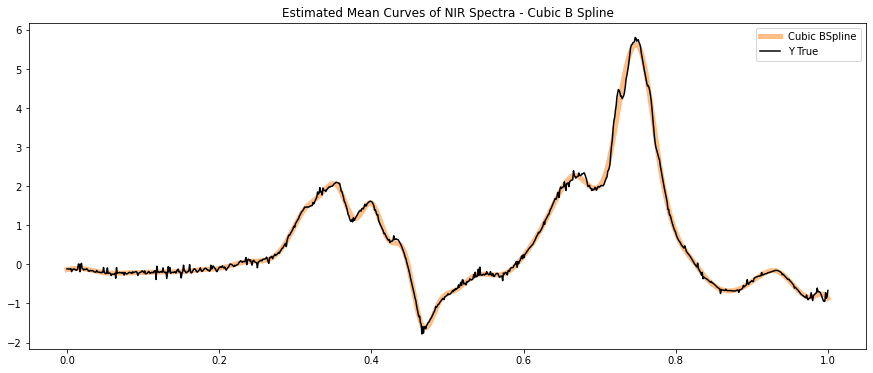

In [13]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(X, y_pred_cubic_bspline, 'tab:orange', linewidth=5, alpha=0.5, label ='Cubic BSpline')
plt.plot(X, y_true, 'black', label='Y True')


plt.legend()
plt.title('Estimated Mean Curves of NIR Spectra - Cubic B Spline')
plt.show()

## Part C - Smoothing Spline
**Report the optimal lambda and MSE**

In [14]:
n = 1000
X = np.linspace(0,1,n)

# Generate B-Spline basis using optimal knots from part b
knots = np.linspace(0, 1,  int(x_min))
B = BSplineBasis(X, knots, 2)[:,:-2]

B2 = np.diff(B, axis=0, n=2)*(n-1)**2  # Numerical derivative
omega = B2.T.dot(B2)/(n-2)
lams = np.arange(0, 1e-3, 1e-6)
p = len(lams)
RSS = []
MSE = []
df = []
for lam in lams:
    S = B@np.linalg.inv(B.T@B+lam*omega)@B.T  # Not great but we still need to get the trace of S
    yhat = S.dot(y_true)
    RSS.append(((yhat-y_true)**2).sum())
    MSE.append(((yhat-y_true)**2).sum()/n)
    df.append(np.trace(S))
RSS = np.array(RSS)
MSE = np.array(MSE)
df = np.array(df)

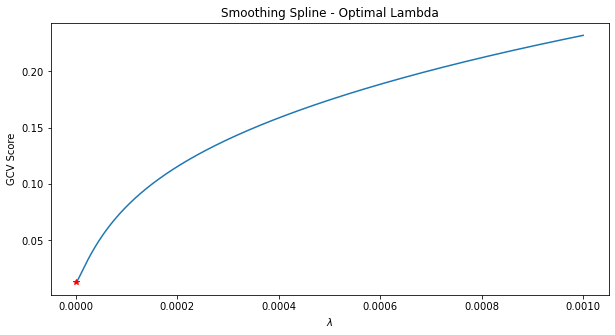

In [15]:
# Plot
GCV = (RSS/n)/(1-df/n)**2
i = np.argmin(GCV)
m = GCV[i]

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(lams, GCV, label='GCV')
plt.plot(lams[i], m, 'r*', label='Lowest GCV')
plt.title("Smoothing Spline - Optimal Lambda")
plt.xlabel('$\lambda$')
plt.ylabel('GCV Score')
plt.show()

In [16]:
S = B@np.linalg.inv(B.T@B+lams[i]*omega)@B.T  # Not great but we still need to get the trace of S
y_pred_smooth_spline = S.dot(y_true)

In [17]:
print("----- Results: Smoothing Spline -----")
print("Optimal Lambda = " + str(lams[i]))
print("GCV of Optimal Lambda: " +str(GCV[i]))
print("MSE of Optimal Lambda: " +str(MSE[i]))

----- Results: Smoothing Spline -----
Optimal Lambda = 0.0
GCV of Optimal Lambda: 0.012692787811650945
MSE of Optimal Lambda: 0.011527704125631692


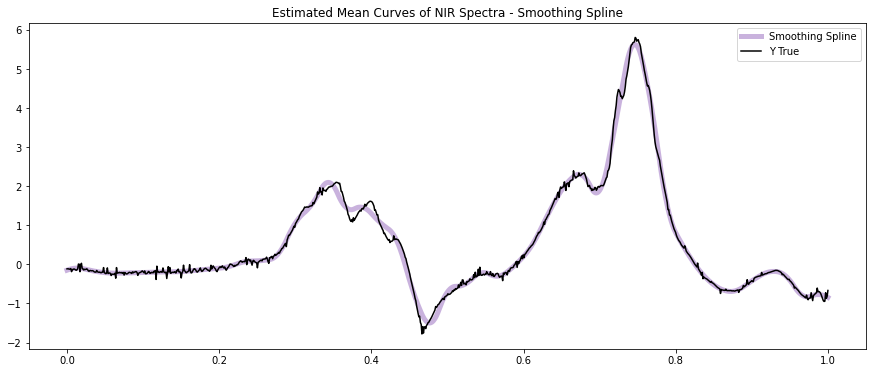

In [18]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(X, y_pred_smooth_spline, 'tab:purple', linewidth=5, alpha=0.5, label ='Smoothing Spline')
plt.plot(X, y_true, 'black', label='Y True')

plt.legend()
plt.title('Estimated Mean Curves of NIR Spectra - Smoothing Spline')
plt.show()

## Part D - Gaussian Kernel
**Use 5-fold cross validation to determine the optimal kernel bandwidth. Report the optimal bandwidth and the cross validation MSE.**

Note: I couldn't figure out how to make the 5-fold cross validation work in this question. I used the LeaveOneOut cross validation from the example code and modified to use the Gaussian kernel and applied it to soil sample data.

In [19]:
def kerf(z):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-z ** 2 / 2.)

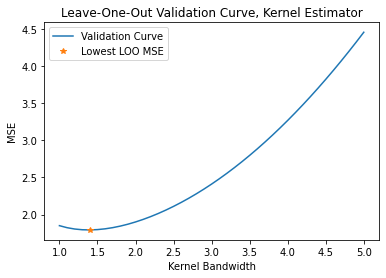

In [20]:
x = np.arange(1000)
y = y_true

# leave-one-out CV
bandwidths = np.arange(1, 5.001, 0.1)
MSEs = []
for w in bandwidths:
    loo = LeaveOneOut()
    errs = []
    for trg, tst in loo.split(x):
        z = kerf((x[tst]-x[trg])/w)
        yke = np.average(y[trg], weights=z)
        errs.append(y[tst]-yke)
    MSEs.append(sum([err**2 for err in errs]))
MSEs = np.array(MSEs).squeeze()
w_star = bandwidths[np.argmin(MSEs)]
plt.plot(bandwidths, MSEs, label='Validation Curve')
plt.plot(w_star, min(MSEs),'*', label='Lowest LOO MSE')
plt.title('Leave-One-Out Validation Curve, Kernel Estimator')
plt.xlabel('Kernel Bandwidth')
plt.ylabel('MSE')
plt.legend()
plt.show()



In [21]:
print("----- Results: Gaussian Kernel -----")
print("Optimal Kernel Bandwith: " + str(w_star))
print("Cross Validation MSE: " + str(min(MSEs)))

----- Results: Gaussian Kernel -----
Optimal Kernel Bandwith: 1.4000000000000004
Cross Validation MSE: 1.7938101709607792


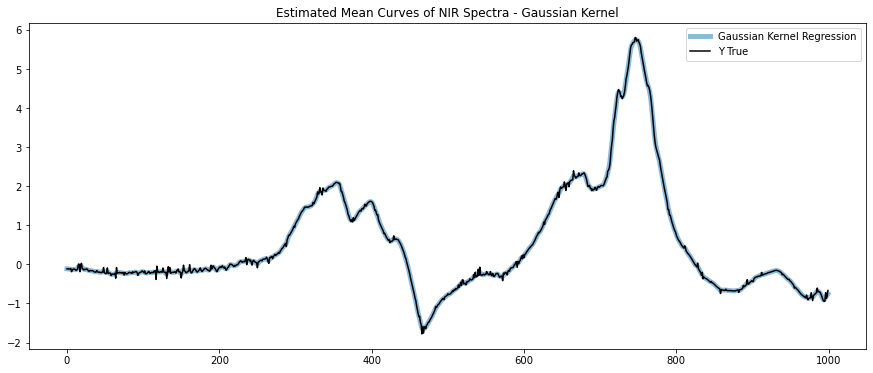

In [22]:
# Interpolation for N values
N = 1000
xx = np.linspace(min(x), max(x), N)
yy = []
for xx_ in xx:
    z = kerf((xx_-x)/w_star)
    yy.append(np.average(y, weights=z))

    
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(xx, yy, 'tab:blue', linewidth=5, alpha=0.5, label='Gaussian Kernel Regression')
plt.plot(x, y, 'black', label='Y True')

plt.legend()
plt.title('Estimated Mean Curves of NIR Spectra - Gaussian Kernel')
plt.show()

### Plots
Plot your estimated curves along with the mean function of NIR spectra of the soil samples.

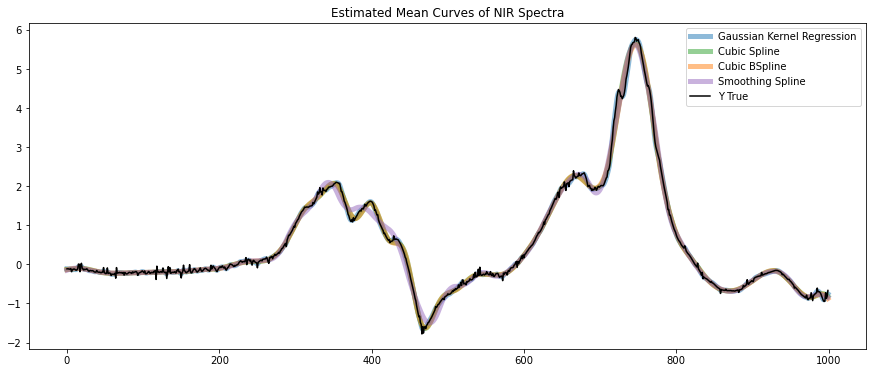

In [23]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(xx, yy, 'tab:blue', linewidth=5, alpha=0.5, label='Gaussian Kernel Regression')
plt.plot(x, y_pred_cubic_spline, 'tab:green',  linewidth=5, alpha=0.5, label ='Cubic Spline')
plt.plot(x, y_pred_cubic_bspline, 'tab:orange', linewidth=5, alpha=0.5, label ='Cubic BSpline')
plt.plot(x, y_pred_smooth_spline, 'tab:purple', linewidth=5, alpha=0.5, label ='Smoothing Spline')
plt.plot(x, y, 'black', label='Y True')


plt.legend()
plt.title('Estimated Mean Curves of NIR Spectra')
plt.show()